In [1]:
import os
import glob
import numpy as np
from matplotlib import pyplot as plt
from osgeo import gdal
import pandas as pd
from keras.utils import to_categorical
import tensorflow as tf
from sklearn.utils import class_weight
import random

In [2]:
train_images = []
image_names = glob.glob(r"C:\Document\University\2023_Spring_Junior\GEOG_491\Dataset\August_Complex\Deep_learning\256\training_image\images/*.tif")
image_names.sort()
for img_path in image_names:
      tiff_image = gdal.Open(img_path, 0)
      band7 = tiff_image.GetRasterBand(7).ReadAsArray()
      band8 = tiff_image.GetRasterBand(8).ReadAsArray()
      band9 = tiff_image.GetRasterBand(9).ReadAsArray()

      X = np.stack((band9, band8, band7), axis=-1)
      train_images.append(X)

train_images = np.array(train_images)
print(np.mean(train_images))
X_train = train_images
print(X_train.shape)

train_masks = []
image_names = glob.glob(r"C:\Document\University\2023_Spring_Junior\GEOG_491\Dataset\August_Complex\Deep_learning\mask\ps\multi\truth_2\train\images/*.tif")
image_names.sort()
for img_path in image_names:
  #  print(img_path)
   tiff_image = gdal.Open(img_path, 0)
   band1 = tiff_image.GetRasterBand(1).ReadAsArray()
   train_masks.append(band1)

train_masks = np.array(train_masks)
y_train = train_masks
print(y_train.shape)

y_train_cat = to_categorical(train_masks, num_classes=4)
y_train_cat = y_train_cat.astype(int)
print(y_train_cat.shape)

C:\Users\wumin\anaconda3\envs\deep_learning\lib\site-packages\osgeo\gdal.py:287: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


1283.7584615587612
(690, 256, 256, 3)
(690, 256, 256)
(690, 256, 256, 4)


In [3]:
train_images_pre = []
image_names = glob.glob(r"C:\Document\University\2023_Spring_Junior\GEOG_491\Dataset\August_Complex\Deep_learning\256\pre\training\images/*.tif")
image_names.sort()
for img_path in image_names:
      # print(img_path)
      tiff_image = gdal.Open(img_path, 0)
      band7 = tiff_image.GetRasterBand(7).ReadAsArray()
      band8 = tiff_image.GetRasterBand(8).ReadAsArray()
      band9 = tiff_image.GetRasterBand(9).ReadAsArray()

      X = np.stack((band9, band8, band7), axis=-1)
      train_images_pre.append(X)

train_images_pre = np.array(train_images_pre)
print(np.mean(train_images_pre))


1283.7590900587


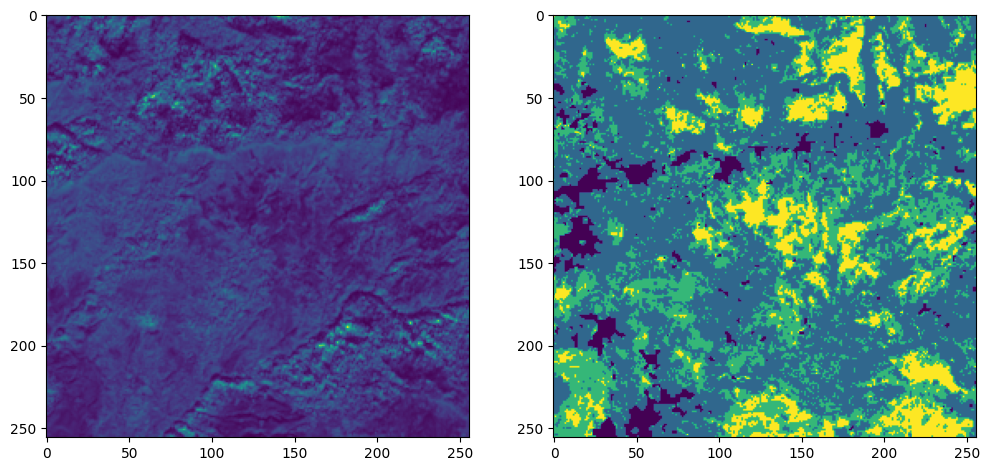

518


In [4]:
#Sanity check, view few images
import random
import numpy as np
image_number = random.randint(0, len(train_images)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape((train_images[image_number, :, :, 2]), (256, 256, 1)))
plt.subplot(122)
plt.imshow(np.reshape(train_masks[image_number], (256, 256, 1)))
plt.show()
print(image_number)

In [5]:
test_images = []
image_names = glob.glob(r"C:\Document\University\2023_Spring_Junior\GEOG_491\Dataset\August_Complex\Deep_learning\256\testing_image\images/*.tif")
image_names.sort()
for img_path in image_names:
      tiff_image = gdal.Open(img_path, 0)
      band7 = tiff_image.GetRasterBand(7).ReadAsArray()
      band8 = tiff_image.GetRasterBand(8).ReadAsArray()
      band9 = tiff_image.GetRasterBand(9).ReadAsArray()

      X = np.stack((band9, band8, band7), axis=-1)
      test_images.append(X)

test_images = np.array(test_images)
print(np.mean(test_images))
print(test_images.shape)

test_masks = []
image_names = glob.glob(r"C:\Document\University\2023_Spring_Junior\GEOG_491\Dataset\August_Complex\Deep_learning\mask\ps\multi\truth_2\test\images/*.tif")
image_names.sort()
for img_path in image_names:
   tiff_image = gdal.Open(img_path, 0)
   band1 = tiff_image.GetRasterBand(1).ReadAsArray()
   test_masks.append(band1)

test_masks = np.array(test_masks)
print(np.unique(test_masks))

y_test_cat = to_categorical(test_masks, num_classes=4)
y_test_cat = y_test_cat.astype(int)
print(y_test_cat.shape)
print(np.unique(y_test_cat))

1314.3571367617008
(36, 256, 256, 3)
[0 1 2 3]
(36, 256, 256, 4)
[0 1]


In [6]:
test_images_pre = []
image_names = glob.glob(r"C:\Document\University\2023_Spring_Junior\GEOG_491\Dataset\August_Complex\Deep_learning\256\pre\testing\images/*.tif")
image_names.sort()
for img_path in image_names:
      tiff_image = gdal.Open(img_path, 0)
      band7 = tiff_image.GetRasterBand(7).ReadAsArray()
      band8 = tiff_image.GetRasterBand(8).ReadAsArray()
      band9 = tiff_image.GetRasterBand(9).ReadAsArray()

      X = np.stack((band9, band8, band7), axis=-1)
      test_images_pre.append(X)

test_images_pre = np.array(test_images_pre)
print(np.mean(test_images_pre))
print(test_images_pre.shape)

1314.3589101720738
(36, 256, 256, 3)


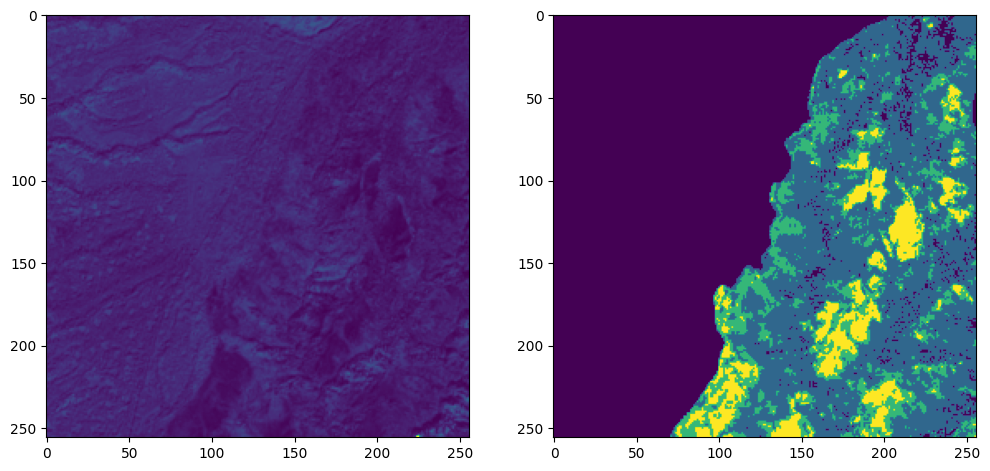

8


In [7]:
# #Sanity check, view few images
image_number = random.randint(0, len(test_images)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape((test_images[image_number, :, :, 2]), (256, 256, 1)))
plt.subplot(122)
plt.imshow(np.reshape(test_masks[image_number], (256, 256, 1)))
plt.show()
print(image_number)

In [8]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Activation, multiply
def conv_block(x, filter_size, size, dropout, batch_norm=False):

    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)

    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)

    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    return conv


def repeat_elem(tensor, rep):

     return layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)

def gating_signal(input, out_size, batch_norm=False):
    x = layers.Conv2D(out_size, (1, 1), padding='same')(input)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

# Getting the x signal to the same shape as the gating signal
    theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  # 16
    shape_theta_x = K.int_shape(theta_x)

# Getting the gating signal to the same number of filters as the inter_shape
    phi_g = layers.Conv2D(inter_shape, (1, 1), padding='same')(gating)
    upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3),
                                 strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                 padding='same')(phi_g)  # 16

    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = repeat_elem(upsample_psi, shape_x[3])

    y = layers.multiply([upsample_psi, x])

    result = layers.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = layers.BatchNormalization()(result)
    return result_bn

def res_conv_block(x, filter_size, size, dropout, batch_norm=False):

    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation('relu')(conv)

    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    #conv = layers.Activation('relu')(conv)   
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    shortcut = layers.Conv2D(size, kernel_size=(1, 1), padding='same')(x)
    if batch_norm is True:
        shortcut = layers.BatchNormalization(axis=3)(shortcut)

    res_path = layers.add([shortcut, conv])
    res_path = layers.Activation('relu')(res_path)    
    return res_path


In [9]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Activation, multiply
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K

def Bi_UNet(input_shape, NUM_CLASSES=4, dropout_rate=0.2, batch_norm=True):

    # network structure
    FILTER_NUM = 16 # number of filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters


    input1 = layers.Input(input_shape)

    # Downsampling layers post
    # DownRes 1, convolution + pooling
    conv_128_1 = conv_block(input1, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64_1 = layers.MaxPooling2D(pool_size=(2,2))(conv_128_1)
    # DownRes 2
    conv_64_1 = conv_block(pool_64_1, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32_1 = layers.MaxPooling2D(pool_size=(2,2))(conv_64_1)
    # DownRes 3
    conv_32_1 = conv_block(pool_32_1, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16_1 = layers.MaxPooling2D(pool_size=(2,2))(conv_32_1)
    # DownRes 4
    conv_16_1 = conv_block(pool_16_1, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8_1 = layers.MaxPooling2D(pool_size=(2,2))(conv_16_1)
    # DownRes 5, convolution only
    conv_8_1 = conv_block(pool_8_1, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Downsampling layers pre
    input2 = layers.Input(input_shape)
    # DownRes 1, convolution + pooling
    conv_128_2 = conv_block(input2, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64_2 = layers.MaxPooling2D(pool_size=(2,2))(conv_128_2)
    # DownRes 2
    conv_64_2 = conv_block(pool_64_2, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32_2 = layers.MaxPooling2D(pool_size=(2,2))(conv_64_2)
    # DownRes 3
    conv_32_2 = conv_block(pool_32_2, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16_2 = layers.MaxPooling2D(pool_size=(2,2))(conv_32_2)
    # DownRes 4
    conv_16_2 = conv_block(pool_16_2, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8_2 = layers.MaxPooling2D(pool_size=(2,2))(conv_16_2)
    # DownRes 5, convolution only
    conv_8_2 = conv_block(pool_8_2, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    x8 = concatenate([conv_8_1, conv_8_2])
    x16 = concatenate([conv_16_1, conv_16_2])
    x32 = concatenate([conv_32_1, conv_32_2])
    x64 = concatenate([conv_64_1, conv_64_2])
    x128 = concatenate([conv_128_1, conv_128_2])

    # Upsampling layers

    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(x8)
    up_16 = layers.concatenate([up_16, x16], axis=3)
    up_conv_16 = conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7

    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, x32], axis=3)
    up_conv_32 = conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8

    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, x64], axis=3)
    up_conv_64 = conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9

    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, x128], axis=3)
    up_conv_128 = conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers

    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization()(conv_final)
    conv_final = layers.Activation('softmax')(conv_final)

    # Model
    model = models.Model(inputs=[input1, input2], outputs=[conv_final], name="Bi_UNet")
    return model

In [10]:
import tensorflow as tf
from keras import backend as K

def categorical_mean_iou_loss(y_true, y_pred):
    y_true = tf.cast(y_true, y_pred.dtype) 

    # Calculate intersection and union
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1, 2])
    union = K.sum(y_true, axis=[1, 2]) + K.sum(y_pred, axis=[1, 2]) - intersection

    # Calculate mean IoU loss
    iou = (intersection + K.epsilon()) / (union + K.epsilon())
    mean_iou_loss = 1 - K.mean(iou)

    return mean_iou_loss

In [11]:
class MyMeanIOU(tf.keras.metrics.MeanIoU):
    def update_state(self, y_true, y_pred, sample_weight=None):
        return super().update_state(tf.argmax(y_true, axis=-1), tf.argmax(y_pred, axis=-1), sample_weight)

In [12]:
# training
def get_model():
    return Bi_UNet((256, 256, 3))
model = get_model()
model.compile(optimizer = 'adam', loss=categorical_mean_iou_loss, metrics = [MyMeanIOU(4)])
# tf.keras.losses.CategoricalCrossentropy()
# categorical_focal_loss(gamma=2.0, alpha=0.25)

In [13]:
model.summary()

Model: "Bi_UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                           

In [15]:
from keras_flops import get_flops
# Calculae FLOPS
flops = get_flops(model, batch_size=1)
print(f"FLOPS: {flops / 10 ** 9:.03} G")
print(flops)

FLOPS: 11.0 G
11035490784


In [ ]:
train_list = [X_train, train_images_pre]
test_list = [test_images, test_images_pre]

In [ ]:
# fitting model
import time
start_time = time.time()
history = model.fit(train_list, y_train_cat,
                    batch_size = 8,
                    verbose=1,
                    epochs=30,
                    validation_split=0.1,
                    # validation_data=(test_list, y_test_cat),
                    shuffle=True)

end_time = time.time()
elapsed_time = end_time - start_time
print("Training time: {:.2f} seconds".format(elapsed_time))

In [ ]:
from sklearn.metrics import classification_report
from sklearn import metrics
import tensorflow as tf
predicted = np.expand_dims(test_images, 0)
prediction = (model.predict(test_list))
print(prediction.shape)
predicted_img = np.argmax(prediction, axis=3)[:,:,:]
y_test_pred = test_masks
# print(y_test.shape)
print(predicted_img.shape)
cm = metrics.confusion_matrix(y_test_pred.reshape(-1), predicted_img.reshape(-1))
print(cm, "\n")
print(classification_report(y_test_pred.reshape(-1), predicted_img.reshape(-1), digits=4))

from keras.metrics import MeanIoU
IOU_keras = MeanIoU(num_classes=4)
IOU_keras.update_state(y_test_pred.reshape(-1), predicted_img.reshape(-1))
print("Mean IoU = ", IOU_keras.result().numpy())
values = np.array(IOU_keras.get_weights()).reshape(4, 4)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0] + values[2,0] + values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1] + values[2,1] + values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2] + values[1,2] + values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3] + values[1,3] + values[2,3])
print("class1 IoU = ", class1_IoU)
print("class2 IoU = ", class2_IoU)
print("class3 IoU = ", class3_IoU)
print("class4 IoU = ", class4_IoU)

m = tf.keras.metrics.Accuracy()
m.update_state(y_test_pred.reshape(-1), predicted_img.reshape(-1))
print('\n', 'Accuracy = ', m.result().numpy())

from sklearn.metrics import cohen_kappa_score
kappa_score = cohen_kappa_score(y_test_pred.reshape(-1), predicted_img.reshape(-1))
print("Kappa:", kappa_score)

In [ ]:
# Ramdomly check on test images
image_number = random.randint(0, len(test_images)-1)
predicted1 = np.expand_dims(test_list[0][image_number], 0)
predicted2 = np.expand_dims(test_list[1][image_number], 0)
predict_list = [predicted1, predicted2]

prediction = (model.predict(predict_list))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]
plt.figure(figsize=(12, 6))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(np.reshape((test_images[image_number, :, :, 2]), (256, 256, 1)))
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(np.reshape(test_masks[image_number], (256, 256, 1)))
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(np.reshape((predicted_img), (256, 256, 1)))
plt.show()